In [265]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [266]:
df = pd.read_csv("train.csv")
df = df[df["player_positions"].str.contains("GK", na=False)]
df.dropna(subset=["value_eur"], inplace=True)

In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1723 entries, 3 to 15384
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   1723 non-null   int64  
 1   id                           1723 non-null   int64  
 2   short_name                   1723 non-null   object 
 3   long_name                    1723 non-null   object 
 4   player_positions             1723 non-null   object 
 5   overall                      1723 non-null   int64  
 6   potential                    1723 non-null   int64  
 7   value_eur                    1723 non-null   float64
 8   wage_eur                     1723 non-null   float64
 9   age                          1723 non-null   int64  
 10  dob                          1723 non-null   object 
 11  height_cm                    1723 non-null   int64  
 12  weight_kg                    1723 non-null   int64  
 13  club_team_id          

In [268]:
df["overall_potential"] = df["overall"] * df["potential"]

In [269]:
club_map = df.groupby('club_name', observed=True)['value_eur'].median().sort_values().rank().to_dict()
df["club_name"] = df["club_name"].map(club_map)

league_map = df.groupby('league_name', observed=True)['value_eur'].median().sort_values().rank().to_dict()
df["league_name"] = df["league_name"].map(league_map)

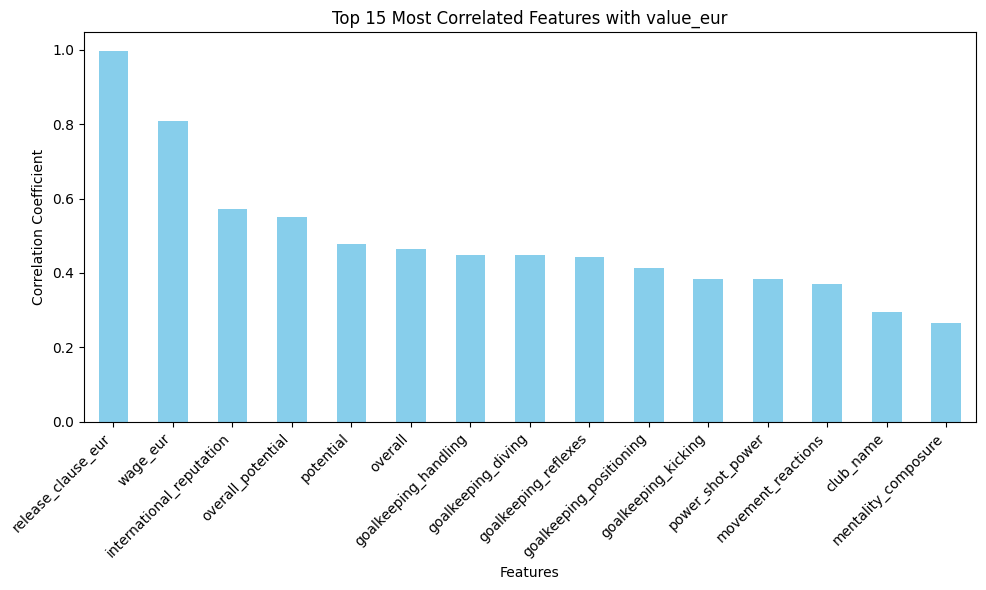

release_clause_eur          0.997330
wage_eur                    0.809991
international_reputation    0.570904
overall_potential           0.550568
potential                   0.476593
overall                     0.465175
goalkeeping_handling        0.449480
goalkeeping_diving          0.447461
goalkeeping_reflexes        0.442109
goalkeeping_positioning     0.412582
goalkeeping_kicking         0.384208
power_shot_power            0.383625
movement_reactions          0.369163
club_name                   0.295131
mentality_composure         0.266425
Name: value_eur, dtype: float64


In [270]:
import matplotlib.pyplot as plt

# Select only numeric columns (non-categorical variables)
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Get the correlations with 'value_eur' and sort them
value_corr = correlation_matrix['value_eur'].sort_values(ascending=False)

# Select the top 15 most correlated features (excluding 'value_eur' itself)
top_15_corr = value_corr[1:16]

# Plot the correlations
plt.figure(figsize=(10, 6))
top_15_corr.plot(kind='bar', color='skyblue')
plt.title('Top 15 Most Correlated Features with value_eur')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(top_15_corr)

In [271]:
X = df.drop(columns=["value_eur"], errors='ignore')
y = df["value_eur"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [272]:
# List of columns to keep based on the top correlations with 'value_eur'
cols_to_keep = [
    "release_clause_eur", "wage_eur", 
    "international_reputation", "overall_potential", 
    "goalkeeping_handling", "goalkeeping_diving", 
    "goalkeeping_reflexes", "goalkeeping_positioning", 
    "goalkeeping_kicking"
]

# Filter the DataFrame to keep only the specified columns
X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

In [273]:
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=50,
    random_state=42,
)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R^2: {r2_score(y_train, train_preds)}")
print(f"Test R^2: {r2_score(y_test, test_preds)}")

Train RMSE: 760557.3338021102
Test RMSE: 531822.9997200699
Train R^2: 0.988112492918213
Test R^2: 0.9933713425594822


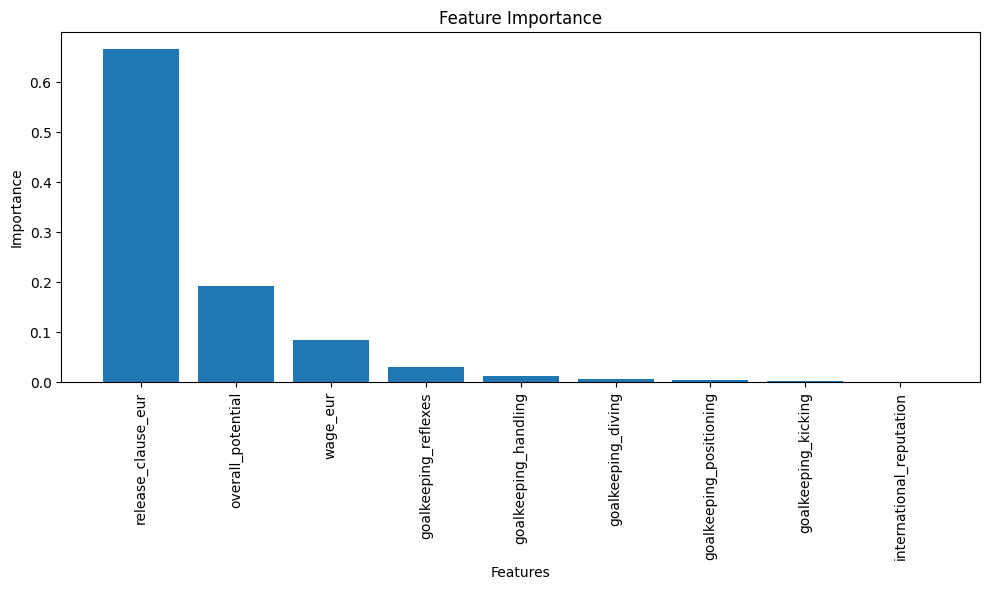

In [274]:
# Get feature importance
importances = rf.feature_importances_
feature_names = X_train.columns

# Sort feature importance in descending order
sorted_indices = importances.argsort()[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [275]:
# Initialize the XGBoost Regressor
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

# Train the model
xgb.fit(X_train, y_train)

# Make predictions
train_preds_xgb = xgb.predict(X_train)
test_preds_xgb = xgb.predict(X_test)

# Evaluate the model
train_rmse_xgb = root_mean_squared_error(y_train, train_preds_xgb)
test_rmse_xgb = root_mean_squared_error(y_test, test_preds_xgb)

print(f"XGBoost Train RMSE: {train_rmse_xgb}")
print(f"XGBoost Test RMSE: {test_rmse_xgb}")
print(f"XGBoost Train R^2: {r2_score(y_train, train_preds_xgb)}")
print(f"XGBoost Test R^2: {r2_score(y_test, test_preds_xgb)}")

XGBoost Train RMSE: 29242.74088093175
XGBoost Test RMSE: 806027.3829643304
XGBoost Train R^2: 0.9999824263074667
XGBoost Test R^2: 0.9847738207671238


In [ ]:
X_train["release_clause_eur"].fillna(X_train["release_clause_eur"].median(), inplace=True)
X_test["release_clause_eur"].fillna(X_test["release_clause_eur"].median(), inplace=True)

In [ ]:
from sklearn.linear_model import LinearRegression

X_train = X_train['release_clause_eur']
X_test = X_test['release_clause_eur']
# Initialize the Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Make predictions
train_preds_lr = lr.predict(X_train)
test_preds_lr = lr.predict(X_test)

# Evaluate the model

train_rmse_lr = root_mean_squared_error(y_train, train_preds_lr)
test_rmse_lr = root_mean_squared_error(y_test, test_preds_lr)

print(f"Linear Regression Train RMSE: {train_rmse_lr}")
print(f"Linear Regression Test RMSE: {test_rmse_lr}")

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

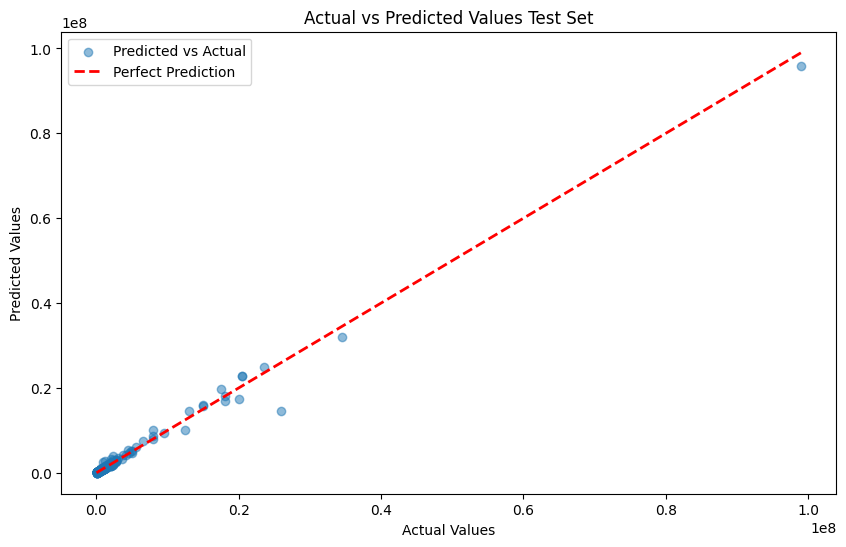

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_preds, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values Test Set")
plt.legend()
plt.show()

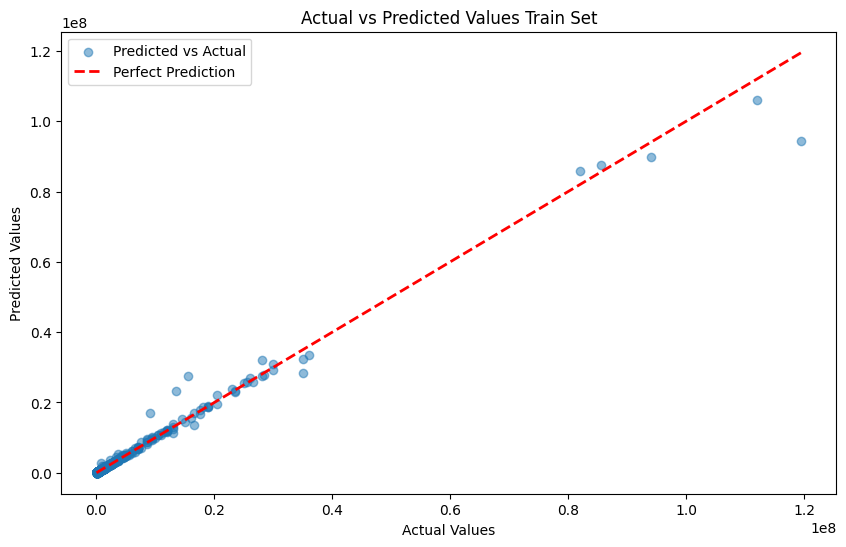

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_preds, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values Train Set")
plt.legend()
plt.show()